# Defining modified Rankin Scale (mRS) probability distributions for untreated patients, and predicted distributions if treatment given at time of stroke onset

## Plain English Summary

Disability levels may be measured in various ways. In this project we are using the modified Rankin Scale (mRS). It is a commonly used scale for measuring the degree of disability or dependence in the daily activities of people who have suffered a stroke.

The scale runs from 0-6, running from perfect health without symptoms to death:

| Score | Description |
|---|---|
| 0 | No symptoms. |
| 1 | No significant disability. Able to carry out all usual activities, despite some symptoms. |
| 2 | Slight disability. Able to look after own affairs without assistance, but unable to carry out all previous activities. |
| 3 | Moderate disability. Requires some help, but able to walk unassisted. |
| 4 | Moderately severe disability. Unable to attend to own bodily needs without assistance, and unable to walk unassisted. |
| 5 | Severe disability. Requires constant nursing care and attention, bedridden, incontinent. |
| 6 | Dead. |


When we predict the outcome of a person who has had a stroke, we want to be able to say what is the likely improvement in disability level they would experience due to the treatment.

The improvement they can get will depend on the time from when their stroke symptoms began and when they receive treatment. The best possible outcome would be if they were treated immediately after they had their stroke. The benefit of treatment reduces over time until the treatment no longer offer any benefit, and they will not be better off than having no treatment.

In this notebook we describe how we estimate the spread of disability levels if treatment was given immediately after the stroke, and what the spread of disability levels would be if the treatment was given at a time when it was no longer effective. These are two key pieces of information we will later use to estimate the spread of disability levels if we know the time after stroke symptoms began when a person was treated with either thrombolysis (clot-busting medication) or thrombectomy (physical removal of a clot). 

## Aims

We define probability distributions at times from onset to treatment of zero hours, and of the no-effect time, $t_{ne}$. Any data sets containing mRS=6 (death) have the associated probability $P(\mathrm{mRS}=6)$ removed, and the remaining values are normalised so that $P(\mathrm{mRS}\leq5)=1.0$.

All of the probability distributions are plotted here as stacked horizontal bars.

Most of the data is taken directly from the source, but some of the probability distributions here have been calculated from multiple data sets. These more complicated distributions are derived later on in this notebook.

## Descriptions of the mRS data sets used here:

| Description | Time zero | No-effect time (no treatment) | 
| :-- | :-- | :-- |
| Pre-stroke | The estimated pre-stroke mRS scores from SSNAP data, as used in the SAMueL-1 project. | N/A |
| Haemorrhaegic | N/A | N/A|
| nLVO - untreated | N/A | [Explained here](#nLVO-untreated:-time-of-no-effect). The weighted combination of the no-effect-time nLVO and LVO combined data from Lees et al. 2010 (100%) and the no-effect-time LVO-only data (minus 23%, taken as the incidence of LVO in all ischaamic strokes using NIHSS >10 in SAMueL data), then further scaled to match $P(\mathrm{mRS}\leq1, t=t_\mathrm{ne})=0.46$ from Holodinsky et al. 2018. |
| nLVO - thrombolysis | [Explained here](#nLVO-thrombolysis:-t=0). The weighted combination of pre-stroke (87%) and untreated nLVO at no-effect-time (13%), where weights are chosen to match the $P(\mathrm{mRS}\leq1, t=0)=0.63$ from Holodinsky et al. 2018. | Same as above. |
| LVO - untreated | N/A | The control population from Goyal et al. 2016. |
| LVO - thrombolysis only | [Explained here](#LVO-thrombolysis-only:-t=0). Weighted combination of the no-effect-time LVO data (82%) and the pre-stroke data (18%). | Same as above. |
| LVO - thrombectomy <br /> with/out thrombolysis | [Explained here](#LVO-thrombectomy:-t=0). The weighted combination of pre-stroke (75%) and untreated LVO at no-effect-time (25%), where weights are chosen to match the predicted $P(\mathrm{mRS}\leq2, t=0)=0.68$ from Fransen et al. 2016. | Same as above. | 

[References can be found here.](#References)

---

## Notebook admin

In [1]:
# Keep notebook cleaner once finalised
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import packages
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
# Set up MatPlotLib
%matplotlib inline
# Change default colour scheme:
plt.style.use('seaborn-colorblind')

In [4]:
# Set NumPy to pront 4 decimal places
np.set_printoptions(precision=4)

---

## Import data

The mRS probability distributions are stored in dictionaries in a file.

The dictionaries are named using these strings:
+ `t0_treatment` - data from time $t=0$hr
+ `no_treatment` - data from the no-effect time $t=t_{ne}$
+ `lvo` - large-vessel occlusion
+ `nlvo` - non-large-vessel occlusion
+ `ich` - intra-cerebral haemorrhaege
+ `pre-stroke` - data recorded before the onset of stroke (all patients)
+ `pre-stroke_nlvo` - data recorded before the onset of stroke (NIHSS 0-10)
+ `pre-stroke_lvo` - data recorded before the onset of stroke (NIHSS 11+)
+ `oly` - thromb**oly**sis used
+ `ect` - thromb**ect**omy used.

Each dictionary contains an entry for:
+ `dist_mrs6` - mRS distribution including mRS=6. If the mRS=6 data is unknown, it is set to 0. 
+ `dist` - mRS distribution excluding mRS=6.
+ `bins` - cumulative probabilities of `dist`.

We import the data corresponding to the table above from `mRS_datasets.py` in the `outcome_utilities` directory:

In [5]:
from outcome_utilities.mRS_datasets import (
    dict_pre_stroke, dict_pre_stroke_nlvo, dict_pre_stroke_lvo,
    dict_t0_treatment_ich,      dict_no_treatment_ich, 
    dict_t0_treatment_nlvo_lvo, dict_no_treatment_nlvo_lvo,
    dict_t0_treatment_lvo,      dict_no_treatment_lvo,
    dict_t0_treatment_lvo_ivt,  dict_no_treatment_lvo_ivt,
    dict_t0_treatment_lvo_mt,  dict_no_treatment_lvo_mt,
    dict_t0_treatment_nlvo,     dict_no_treatment_nlvo, 
    dict_t0_treatment_nlvo_ivt, dict_no_treatment_nlvo_ivt)

__Invalid data:__

Some of the probability distributions are unknown. In these cases, we fill the arrays with placeholder negative values. For example, we have no data for intra-cerebral haemorrhaege at time zero:

In [6]:
dict_t0_treatment_ich['dist_mrs6']

array([-1, -1, -1, -1, -1, -1, -1])

Since we never ordinarily expect negative probabilities, seeing a negative number in one of the lists is an indication that the data is invalid.

---

## Plot the data

For our convenience in this notebook, we'll gather all of the imported data into one big list:

In [7]:
full_data_list = [
    [dict_pre_stroke,            dict_pre_stroke,            'Pre-stroke'],
    [dict_pre_stroke_nlvo,       dict_pre_stroke_nlvo,       'Pre-stroke_nlvo'],
    [dict_pre_stroke_lvo,        dict_pre_stroke_lvo,        'Pre-stroke_lvo'],
    [dict_t0_treatment_ich,      dict_no_treatment_ich,      'Haemorrhagic'],
    [dict_t0_treatment_nlvo_lvo, dict_no_treatment_nlvo_lvo, 'nLVO/LVO combined IVT'],
    [dict_t0_treatment_lvo,      dict_no_treatment_lvo,      'LVO untreated'],
    [dict_t0_treatment_lvo_ivt,  dict_no_treatment_lvo_ivt,  'LVO IVT'],
    [dict_t0_treatment_lvo_mt,  dict_no_treatment_lvo_mt,  'LVO MT'],
    [dict_t0_treatment_nlvo,     dict_no_treatment_nlvo,     'nLVO untreated'],
    [dict_t0_treatment_nlvo_ivt, dict_no_treatment_nlvo_ivt, 'nLVO IVT']
    ]

### Stacked bars

Define a function for plotting the stacked horizontal bar:

In [8]:
def draw_horizontal_bar(dist,label=''):
    """
    Draw a stacked horizontal bar chart of the values in 'dist'.
    
    dist  - list or np.array. The probability distribution 
            (non-cumulative).
    label - string. The name printed next to these stacked bars.
    """
    colour_list = plt.rcParams['axes.prop_cycle'].by_key()['color']
    # The first bar will start at this point on the x-axis:
    left = 0
    for i in range(len(dist)):
        # Draw a bar starting from 'left', the end of the previous bar,
        # with a width equal to the probability of this mRS:
        plt.barh(label, width=dist[i], left=left, height=0.5, 
                 label=f'{i}', edgecolor='k', color=colour_list[i%6])
        # Update 'left' with the width of the current bar so that the 
        # next bar drawn will start in the correct place.    
        left += dist[i]

In [9]:
def draw_connections(dist_t0, dist_tne, top_tne=0.25, bottom_t0=0.75):
    """
    Draw lines connecting the mRS bins in the top and bottom rows.
    
    dist_t0, dist_tne - lists or arrays. Probability distributions.
    top_tne, bottom_t0 - floats. y-coordinates just inside the bars. 
    """
    left_t0   = 0.0
    left_tne  = 0.0
    for i, d_t0 in enumerate(dict_t0['dist_mrs6']):
        left_t0  +=  dict_t0['dist_mrs6'][i]
        left_tne += dict_tne['dist_mrs6'][i]
        plt.plot([left_t0,left_tne],[bottom_t0,top_tne],color='k')

Run through each row of the full data list in turn and plot its data:

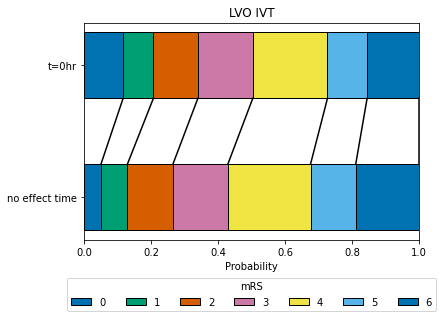

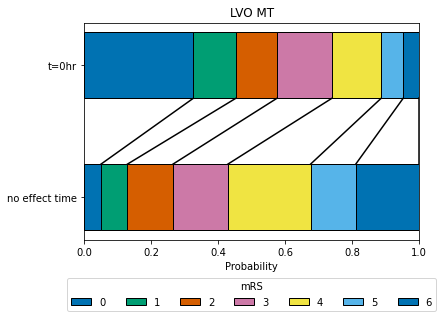

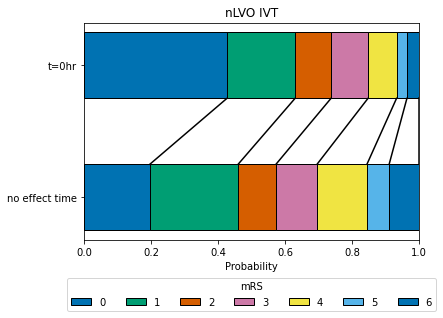

In [10]:
for data_list in full_data_list:
    
    dict_t0  = data_list[0]
    dict_tne = data_list[1]
    label    = data_list[2]
    
    # Only plot specific treatments
    if label in ['LVO IVT', 'LVO MT', 'nLVO IVT', 'nLVO and LVO combined IVT']:
            
        draw_horizontal_bar(dict_tne['dist_mrs6'], 'no effect time')

        # Add legend now to prevent doubling all the labels:
        plt.legend(loc='center',ncol=7, title='mRS', 
                   bbox_to_anchor=[0.5,0.0,0.0,-0.5])   # Legend below axis.

        draw_horizontal_bar(dict_t0['dist_mrs6'], 't=0hr')

        # Draw connecting lines between the two mRS groups:
        if np.sum(dict_t0['dist_mrs6'])>0 and np.sum(dict_tne['dist_mrs6'])>0:
            draw_connections(dict_t0['dist_mrs6'], dict_tne['dist_mrs6'])
      
        plt.xlabel('Probability')
        plt.title(label)
        plt.xlim(0,1)
        plt.savefig(f'./images/{label}.jpg', dpi=300, bbox_inches='tight', 
            pad_inches=0.2)
        plt.show()

In [11]:
combine_data = dict()
for row in full_data_list:
    stroke_type = row[-1]
    if stroke_type in ['LVO IVT', 'LVO MT', 'nLVO IVT', 'nLVO and LVO combined IVT']:
        index = (stroke_type, 't0')
        combine_data[index] = row[0]['dist_mrs6']
        index = (stroke_type, 'no_effect')
        combine_data[index] = row[1]['dist_mrs6']
df = pd.DataFrame(combine_data).T
index_labels = ['stroke_type', 'effect']
df.index.names = index_labels

## Tabulate and save key treatment data

In [12]:
combine_data = dict()
for row in full_data_list:
    stroke_type = row[-1]
    if stroke_type in ['LVO IVT', 'LVO MT', 'nLVO IVT', 'nLVO and LVO combined IVT']:
        index = (stroke_type, 't0')
        combine_data[index] = row[0]['dist_mrs6']
        index = (stroke_type, 'no_effect')
        combine_data[index] = row[1]['dist_mrs6']
df = pd.DataFrame(combine_data).T
index_labels = ['stroke_type', 'effect']
df.index.names = index_labels
df.to_csv('./outcome_utilities/mrs_dist.csv')

In [13]:
df

0         1         2         3         4  \
stroke_type effect                                                        
LVO IVT     t0         0.116221  0.090513  0.132837  0.164038   0.22302   
            no_effect      0.05     0.079     0.136     0.164     0.247   
LVO MT      t0         0.325921  0.126969  0.122823  0.164158  0.147081   
            no_effect      0.05     0.079     0.136     0.164     0.247   
nLVO IVT    t0         0.426592  0.203408   0.10733  0.110477   0.08523   
            no_effect  0.196394  0.263606  0.113059  0.122634  0.148942   

                              5         6  
stroke_type effect                         
LVO IVT     t0         0.118392   0.15498  
            no_effect     0.135     0.189  
LVO MT      t0         0.065798   0.04725  
            no_effect     0.135     0.189  
nLVO IVT    t0          0.03093  0.036034  
            no_effect  0.066257  0.089108

---

# Distributions that require further explanation

---

## LVO thrombolysis only: t=0

Summary: Weighted distribution of 18% full effect (using the time zero pre-stroke distribution) with 82% no effect (using the no-effect-time LVO distribution), as in Holodinsky et al. 2018. 

Steps:
1. Gather the known data.
    + Pre-stroke probability distribution
    + No-effect LVO probability distribution
    + Weights of 18% and 82% respectively.
1. Multiply each distribution by its weighting, and then sum the two weighted distributions.
 
Result: Probability distribution at time zero for the LVO patients treated with thrombolysis.

__Step 1:__ Use the following imported datasets and known values: 

In [14]:
mrs_prob_dist_pre_stroke = dict_pre_stroke_lvo['dist_mrs6']
mrs_prob_dist_no_treatment_lvo = dict_no_treatment_lvo['dist_mrs6']

In [15]:
from outcome_utilities.mRS_datasets import (
    weight_pre_stroke_lvo_ivt, weight_no_treatment_lvo_ivt)

print('Weighting for pre-stroke data:',    weight_pre_stroke_lvo_ivt)
print('Weighting for untreated LVO data:', weight_no_treatment_lvo_ivt)

Weighting for pre-stroke data: 0.18
Weighting for untreated LVO data: 0.82


__Step 2:__ Apply the weights:

In [16]:
mrs_prob_dist_t0_treatment_lvo_ivt = (
    (weight_pre_stroke_lvo_ivt   * mrs_prob_dist_pre_stroke) +
    (weight_no_treatment_lvo_ivt * mrs_prob_dist_no_treatment_lvo) )

__Result:__ The newly-created time zero probability distribution:

In [17]:
[np.round(x, 4) for x in mrs_prob_dist_t0_treatment_lvo_ivt]

[0.1162, 0.0905, 0.1328, 0.164, 0.223, 0.1184, 0.155]

Compare this with the imported distribution:

In [18]:
[np.round(x, 4) for x in dict_t0_treatment_lvo_ivt['dist_mrs6']]

[0.1162, 0.0905, 0.1328, 0.164, 0.223, 0.1184, 0.155]

### Method 2: Calculating weights

__Step 1:__ Use the following imported datasets and known values:

In [19]:
mrs_prob_dist_pre_stroke            = dict_pre_stroke_lvo['dist_mrs6']
mrs_prob_dist_no_treatment_lvo      = dict_no_treatment_lvo['dist_mrs6']

mrs_prob_bins_pre_stroke            = dict_pre_stroke_lvo['bins']
mrs_prob_bins_no_treatment_lvo      = dict_no_treatment_lvo['bins']

__Step 2:__ Calculate the weights needed to give a distribution with $P(\mathrm{mRS}<=1, t=0)=$ 20%:

In [20]:
target_diff  = 0.20 - mrs_prob_bins_pre_stroke[1]
current_diff = (mrs_prob_bins_no_treatment_lvo[1] - 
                mrs_prob_bins_pre_stroke[1])

weight_lvo   = target_diff / current_diff
weight_pre_stroke = 1.0 - weight_lvo

print(f'Weights: {weight_lvo:.4f},', f'{weight_pre_stroke:.4f}')

Weights: 0.8356, 0.1644


__Step 2:__ Apply the weights:

In [21]:
mrs_prob_dist_no_treatment_nlvo = (
    (weight_pre_stroke * mrs_prob_dist_pre_stroke) + 
    (weight_lvo        * mrs_prob_dist_no_treatment_lvo) )

In [22]:
np.sum(mrs_prob_dist_no_treatment_nlvo)

1.0

Currently the bins are unlikely to sum to 1 as required, so they must be normalised:

In [23]:
mrs_prob_dist_no_treatment_nlvo = (
    mrs_prob_dist_no_treatment_nlvo / np.sum(mrs_prob_dist_no_treatment_nlvo))

In [24]:
mrs_prob_dist_no_treatment_nlvo

array([0.1105, 0.0895, 0.1331, 0.164 , 0.2251, 0.1198, 0.1579])

__Step 3:__ Compare the current $P(\mathrm{mRS}\leq1, t=0)$ with the expected 20%.

In [25]:
mrs_prob_bins_no_treatment_nlvo = np.cumsum(mrs_prob_dist_no_treatment_nlvo)

In [26]:
print(f'{mrs_prob_bins_no_treatment_nlvo[1]:0.3f}')

0.200


---

## nLVO untreated: time of no effect

Summary: Estimate from weighted subtraction of the no-effect LVO data from the no-effect combined nLVO and LVO data, and then scale the resulting distribution using a known data point $P(\mathrm{mRS}\leq1, t=t_\mathrm{ne})=0.46$.

Steps:
1. Gather the available data.
    + Probability distribution for no-effect-time combined nLVO and LVO (Lees et al. 2010).
    + Probability distribution for no-effect-time LVO (Goyal et al. 2016).
    + Weights of 100% and -23% respectively (proportion of ischaemic strokes with NIHSS >10 in SAMueL data). 
    + $P(\mathrm{mRS}\leq1, t=t_\mathrm{ne})=0.46$ (Holodinsky et al. 2018).
1. Multiply the distributions by their weights, sum the two, and normalise.
1. Force the calculated $P(\mathrm{mRS}\leq1, t=t_\mathrm{ne})$ to equal 46% and scale the other bins around this value using `scale_dist()`.
 
Result: No-effect-time probability distribution for untreated nLVOs.

__Step 1:__ Use the following imported datasets and known values:

In [27]:
mrs_prob_dist_no_treatment_nlvo_lvo = dict_no_treatment_nlvo_lvo['dist_mrs6']
mrs_prob_dist_no_treatment_lvo      = dict_no_treatment_lvo['dist_mrs6']

In [28]:
from outcome_utilities.mRS_datasets import (
    weight_no_treatment_nlvo_lvo, weight_no_treatment_lvo)

print('Weights:')
print('untreated nLVO and LVO data:', weight_no_treatment_nlvo_lvo)
print('untreated LVO data:         ', weight_no_treatment_lvo)

Weights:
untreated nLVO and LVO data: 1.0
untreated LVO data:          -0.23


__Step 2:__ Apply the weights:

In [29]:
mrs_prob_dist_no_treatment_nlvo = (
    (weight_no_treatment_nlvo_lvo * mrs_prob_dist_no_treatment_nlvo_lvo) + 
    (weight_no_treatment_lvo      * mrs_prob_dist_no_treatment_lvo) )

Normlalise bins to add up to 1.

In [30]:
mrs_prob_dist_no_treatment_nlvo = (
    mrs_prob_dist_no_treatment_nlvo / np.sum(mrs_prob_dist_no_treatment_nlvo))

In [31]:
mrs_prob_dist_no_treatment_nlvo

array([0.1781, 0.239 , 0.122 , 0.1324, 0.1608, 0.0715, 0.0962])

__Step 3:__ Compare the current $P(\mathrm{mRS}\leq1, t=t_\mathrm{ne})$ with the expected 46%.

In [32]:
mrs_prob_bins_no_treatment_nlvo = np.cumsum(mrs_prob_dist_no_treatment_nlvo)

In [33]:
print (f'{mrs_prob_bins_no_treatment_nlvo[1]:0.3f}')

0.417


Because the values don't exactly match, we'll fine-tune $P(\mathrm{mRS}\leq1, t=t_\mathrm{ne})$ to equal 46% and scale the other bins around this movement so that they keep the same proportions.  

In [34]:
mRS_ref_nlvo = 1
p_ref_nlvo   = 0.46

In [35]:
from outcome_utilities.scale_dist import scale_dist

mrs_prob_dist_no_treatment_nlvo, mrs_prob_bins_no_treatment_nlvo = (
    scale_dist(mrs_prob_bins_no_treatment_nlvo, p_ref_nlvo, 
               mRS_ref=mRS_ref_nlvo))

In [36]:
[np.round(x, 4) for x in mrs_prob_dist_no_treatment_nlvo]

[0.1964, 0.2636, 0.1131, 0.1226, 0.1489, 0.0663, 0.0891]

The mRS$\leq$1 bin is 0.46 as required:

In [37]:
[np.round(x, 4) for x in mrs_prob_dist_no_treatment_nlvo]

[0.1964, 0.2636, 0.1131, 0.1226, 0.1489, 0.0663, 0.0891]

Compare with the imported data:

In [38]:
[np.round(x, 4) for x in dict_no_treatment_nlvo['dist_mrs6']]

[0.1964, 0.2636, 0.1131, 0.1226, 0.1489, 0.0663, 0.0891]

### Method 2: Calculating weights

__Step 1:__ Use the following imported datasets and known values:

In [39]:
mrs_prob_dist_no_treatment_nlvo_lvo = dict_no_treatment_nlvo_lvo['dist_mrs6']
mrs_prob_dist_no_treatment_lvo      = dict_no_treatment_lvo['dist_mrs6']

mrs_prob_bins_no_treatment_nlvo_lvo = dict_no_treatment_nlvo_lvo['bins']
mrs_prob_bins_no_treatment_lvo      = dict_no_treatment_lvo['bins']

__Step 2:__ Calculate the weights needed to give a distribution with $P(\mathrm{mRS}<=1, t=t_{\mathrm{ne}})=$ 46%:

In [40]:
target_diff  = 0.46 - mrs_prob_bins_no_treatment_nlvo_lvo[1]
current_diff = (mrs_prob_bins_no_treatment_lvo[1] - 
                mrs_prob_bins_no_treatment_nlvo_lvo[1])

weight_lvo   = target_diff / current_diff
weight_nlvo_lvo = 1.0 - weight_lvo

print(f'Weights: {weight_lvo:.4f},', f'{weight_nlvo_lvo:.4f}')

Weights: -0.4922, 1.4922


__Step 2:__ Apply the weights:

In [41]:
mrs_prob_dist_no_treatment_nlvo = (
    (weight_nlvo_lvo * mrs_prob_dist_no_treatment_nlvo_lvo) + 
    (weight_lvo      * mrs_prob_dist_no_treatment_lvo) )

In [42]:
np.sum(mrs_prob_dist_no_treatment_nlvo)

0.9999999999999999

Currently the bins are unlikely to sum to 1 as required, so they must be normalised:

In [43]:
mrs_prob_dist_no_treatment_nlvo = (
    mrs_prob_dist_no_treatment_nlvo / np.sum(mrs_prob_dist_no_treatment_nlvo))

In [44]:
mrs_prob_dist_no_treatment_nlvo

array([0.1972, 0.2628, 0.12  , 0.1277, 0.1479, 0.0621, 0.0824])

__Step 3:__ Compare the current $P(\mathrm{mRS}\leq1, t=t_\mathrm{ne})$ with the expected 46%.

In [45]:
mrs_prob_bins_no_treatment_nlvo = np.cumsum(mrs_prob_dist_no_treatment_nlvo)

In [46]:
print(f'{mrs_prob_bins_no_treatment_nlvo[1]:0.3f}')

0.460


---

### nLVO thrombolysis: t=0

Summary: Weighted distribution of the pre-stroke and no-effect-time nLVO distributions. The weights are chosen to give $P(\mathrm{mRS}<=1, t=0)=$ 63% (from Holodinsky et al. 2018. )

Steps:
1. Gather the known data.
    + Probability distribution for pre-stroke patients (SAMueL-1).
    + Probability distribution for nLVO patients treated with thrombolysis at the no-effect-time ([calculated here](#nLVO-untreated:-time-of-no-effect)).
    + $P(\mathrm{mRS}<=1, t=0)=$ 63% (Holodinsky et al. 2018).
1. Calculate the weights needed to combine the two probability distributions and ensure that $P(\mathrm{mRS}<=1, t=0)=$ 63%.
1. Multiply the distributions by the weights and sum them. 

Result: A probability distribution for nLVO patients treated with thrombolysis at time zero.
 

__Step 1:__ Use the following imported datasets and known values:

In [47]:
mrs_prob_bins_no_treatment_nlvo_ivt = dict_no_treatment_nlvo_ivt['bins']
mrs_prob_dist_no_treatment_nlvo_ivt = dict_no_treatment_nlvo_ivt['dist_mrs6']

mrs_prob_bins_pre_stroke = dict_pre_stroke_nlvo['bins']
mrs_prob_dist_pre_stroke = dict_pre_stroke_nlvo['dist_mrs6']

__Step 2:__ Calculate the weights needed to give a distribution with $P(\mathrm{mRS}<=1, t=0)=$ 63%:

In [48]:
target_diff  = 0.63 - mrs_prob_bins_no_treatment_nlvo_ivt[1]
current_diff = (mrs_prob_bins_pre_stroke[1] - 
                mrs_prob_bins_no_treatment_nlvo_ivt[1])

weight_pre_stroke_nlvo_ivt   = target_diff / current_diff
weight_no_treatment_nlvo_ivt = 1.0 - weight_pre_stroke_nlvo_ivt

print(f'Weights: {weight_pre_stroke_nlvo_ivt:.4f},',
      f'{weight_no_treatment_nlvo_ivt:.4f}')

Weights: 0.5956, 0.4044


Compare these weights with the values used to create the imported data:

In [49]:
from outcome_utilities.mRS_datasets import (weight_pre_stroke_nlvo_ivt,
                                            weight_no_treatment_nlvo_ivt)

print(f'{weight_pre_stroke_nlvo_ivt:.4f},'
      f'{weight_no_treatment_nlvo_ivt:0.4f}')

0.5956,0.4044


__Step 3:__ Apply the weights:

In [50]:
mrs_prob_dist_t0_treatment_nlvo_ivt = (
    (weight_pre_stroke_nlvo_ivt   * mrs_prob_dist_pre_stroke) +
    (weight_no_treatment_nlvo_ivt * mrs_prob_dist_no_treatment_nlvo_ivt) )


mrs_prob_bins_t0_treatment_nlvo_ivt = np.cumsum(
    mrs_prob_dist_t0_treatment_nlvo_ivt)

__Result:__ The newly-created probability distribution:

In [51]:
[np.round(x, 4) for x in mrs_prob_dist_t0_treatment_nlvo_ivt]

[0.4266, 0.2034, 0.1073, 0.1105, 0.0852, 0.0309, 0.036]

Now $P(\mathrm{mRS}<=1, t=0)=$63% as required:

In [52]:
[np.round(x, 4) for x in mrs_prob_bins_t0_treatment_nlvo_ivt]

[0.4266, 0.63, 0.7373, 0.8478, 0.933, 0.964, 1.0]

Compare with the imported data:

In [53]:
[np.round(x, 4) for x in dict_t0_treatment_nlvo_ivt['dist_mrs6']]

[0.4266, 0.2034, 0.1073, 0.1105, 0.0852, 0.0309, 0.036]

---

### LVO thrombectomy: t=0

Summary: Weighted distribution of the pre-stroke and no-effect-time nLVO distributions. 

Steps:
1. Gather the known data.
    + Probability distribution for pre-stroke patients (SAMueL-1).
    + Probability distribution for LVO patients treated with thrombectomy at the no-effect-time (the control population from Goyal et al. 2016).
    + Hui et al. reported 75% successful recanalisation with thrombectomy.
    + Extrapolating results from Fransen et al. back to t=0 gives the same proportion of patients mRS <= 2 as the pre-stroke mRS int he SAMueL data (therefore this extrapolation would suggest full recovery of all health with thrombectomy theoretically carried out at t=0).

Result: A probability distribution for LVO patients treated with thrombolysis at time zero.

__Step 1:__ Use the following imported datasets and known values:

In [54]:
mrs_prob_bins_no_treatment_lvo_mt = dict_no_treatment_lvo_mt['bins']
mrs_prob_dist_no_treatment_lvo_mt = dict_no_treatment_lvo_mt['dist_mrs6']

mrs_prob_bins_pre_stroke = dict_pre_stroke_lvo['bins']
mrs_prob_dist_pre_stroke = dict_pre_stroke_lvo['dist_mrs6']

__Step 2:__ Apply weight

If weights are chosen to give $P(\mathrm{mRS}<=2, t=0)=$ 68% (extrapolated from Fransen et al., 2016), then the weight is 1.00 for the pre-stroke population.

Hui et al. reported 75% successful recanalisation with thrombectomy. We will assume t=0 treatement would give us a mix of 75% pre-stroke mRS and 25% no-effect mRS.

In [55]:
weight_pre_stroke_lvo_mt = 0.75
weight_no_treatment_lvo_mt = 1.0 - weight_pre_stroke_lvo_mt

print(f'Weights: {weight_pre_stroke_lvo_mt:.4f},' \
      f'{weight_no_treatment_lvo_mt:.4f}')

Weights: 0.7500,0.2500


__Step 3:__ Apply the weights:

In [56]:
mrs_prob_dist_t0_treatment_lvo_mt = (
    (weight_pre_stroke_lvo_mt   * mrs_prob_dist_pre_stroke) +
    (weight_no_treatment_lvo_mt * mrs_prob_dist_no_treatment_lvo_mt))


mrs_prob_bins_t0_treatment_lvo_mt = np.cumsum(
    mrs_prob_dist_t0_treatment_lvo_mt)

__Result:__ The newly-created probability distribution:

In [57]:
[np.round(x, 4) for x in mrs_prob_dist_t0_treatment_lvo_mt]

[0.3259, 0.127, 0.1228, 0.1642, 0.1471, 0.0658, 0.0472]

Compare with the imported data:

In [59]:
[np.round(x, 4) for x in dict_t0_treatment_lvo_mt['dist_mrs6']]

[0.3259, 0.127, 0.1228, 0.1642, 0.1471, 0.0658, 0.0472]

Now $P(\mathrm{mRS}<=2, t=0)=$ 68% as required:

In [61]:
[np.round(x, 4) for x in mrs_prob_bins_t0_treatment_lvo_mt]

[0.3259, 0.4529, 0.5757, 0.7399, 0.887, 0.9528, 1.0]

---

## References

Emberson J, Lees KR, Lyden P, et al. _Effect of treatment delay, age, and stroke severity on the effects of intravenous thrombolysis with alteplase for acute ischaemic stroke: A meta-analysis of individual patient data from randomised trials._ The Lancet 2014;384:1929–35. doi:10.1016/S0140-6736(14)60584-5

Fransen, P., Berkhemer, O., Lingsma, H. et al. Time to Reperfusion and Treatment Effect for Acute Ischemic Stroke: A Randomized Clinical Trial. JAMA Neurol. 2016 Feb 1;73(2):190–6. DOI: 10.1001/jamaneurol.2015.3886

Goyal M, Menon BK, van Zwam WH, et al. _Endovascular thrombectomy after large-vessel ischaemic stroke: a meta-analysis of individual patient data from five randomised trials._ The Lancet 2016;387:1723-1731. doi:10.1016/S0140-6736(16)00163-X

Holodinsky JK, Williamson TS, Demchuk AM, et al. _Modeling Stroke Patient Transport for All Patients With Suspected Large-Vessel Occlusion._ JAMA Neurol. 2018;75(12):1477-1486. doi:10.1001/jamaneurol.2018.2424

Hui W, Wu C, Zhao W, Sun H, Hao J, Liang H, et al. Efficacy and Safety of Recanalization Therapy for Acute Ischemic Stroke With Large Vessel Occlusion. Stroke. 2020 Jul;51(7):2026–35. 

Lees KR, Bluhmki E, von Kummer R, et al. _Time to treatment with intravenous alteplase and outcome in stroke: an updated pooled analysis of ECASS, ATLANTIS, NINDS, and EPITHET trials_. The Lancet 2010;375:1695-703. doi:10.1016/S0140-6736(10)60491-6

SAMueL-1 data on mRS before stroke (DOI: 10.5281/zenodo.6896710): https://samuel-book.github.io/samuel-1/descriptive_stats/08_prestroke_mrs.html

## Appendix: tabulate all data

In [ ]:
# Print the column headings:
print(' '*23 + ',' +' '*11 + ', ' + '-'*36 + 'mRS' + '-'*36)
header = 'Distribution           ,   Time    '
for j in range(7):
    header += ',' + ' '*5 + str(j) + ' '*4 
print(header)
print('-'*112)

# Switch between printing these two times on alternate rows:
times = ['Zero', 'No effect']

# Print each row of data from the big list:
for row in full_data_list:
    for i,data_list in enumerate([row[0], row[1]]):
        # Add label and time to the string:
        p_str = f'{row[2]:23}, {times[i]:10}'
        for j in range(7):
            # Add this mRS value to the string, to 5 decimal places:
            p_str += f',  {data_list["dist_mrs6"][j]:8.5f}'
        print(p_str)